<a href="https://colab.research.google.com/github/dansarmiento/analytics_portfolio/blob/main/predict_depression_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Depression with Machine Learning 

**Project Objective**

This project's goal is to create a robust machine-learning model that can accurately predict the likelihood of depression by analyzing various demographic, academic, and lifestyle factors. The primary aim is to establish a dependable baseline model that can aid in early identification and help uncover the key risk factors associated with mental health challenges.

**Executive Summary**

This project's goal is to create a robust machine-learning model that can accurately predict the likelihood of depression by analyzing various demographic, academic, and lifestyle factors. The primary aim is to establish a dependable baseline model that can aid in early identification and help uncover the key risk factors associated with mental health challenges.

**Key Insights & Findings**

**Exploratory Data Analysis**
Analysis uncovered several powerful predictors of depression:

- Behavioral & Historical Factors: A history of suicidal thoughts and a family history of mental illness showed the strongest correlation with a positive depression diagnosis.
- Environmental Stressors: High levels of Academic Pressure, Work Pressure, and Financial Stress were all significantly correlated with a higher incidence of depression.
- Academic & Professional Life: A lower CGPA and general dissatisfaction with one's studies or job also emerged as notable contributing factors.

**Model Performance**


- Overall Performance: The tuned XGBoost model emerged as the top performer, achieving a weighted-average F1-score of 0.93. The Random Forest model also performed exceptionally well, with an F1-score of 0.93.
- Predictive Strength: The models demonstrated a strong ability to correctly identify individuals with depression (True Positives), which is a critical outcome for any real-world application. The confusion matrices confirm that the models effectively capture the patterns identified during the EDA.

**Conclusion**

The final model is a successful proof-of-concept, demonstrating that machine learning can be effectively used to identify key factors related to depression. The 86% weighted-average F1-score confirms its reliability.


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Preprocessing and Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

# Set plot style
sns.set_style("whitegrid")

# Data Loading and Initial Exploration
The dataset is loaded from a Google Sheet and basic cleaning is performed on the column names. We then visualize the distribution of the target variable, depression, to understand the class balance. The data is imbalanced, with a significantly larger number of non-depressed individuals, which will need to be addressed during the modeling phase.

In [2]:
# import the data
import re

url = 'https://docs.google.com/spreadsheets/d/1YKcR6X_aYEj5s_YABtZiUx9g_-zFJzdIBt6mbv8Uof0/edit?usp=sharing'

# Extract sheet_id using regex
match = re.search(r'/d/([a-zA-Z0-9-_]+)', url)
sheet_id = match.group(1) if match else None

sheet_name = 'train'
gsheet_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
df = pd.read_csv(gsheet_url)
df.columns = df.columns.str.lower().str.replace(' ', '_').str.replace('/', '_')

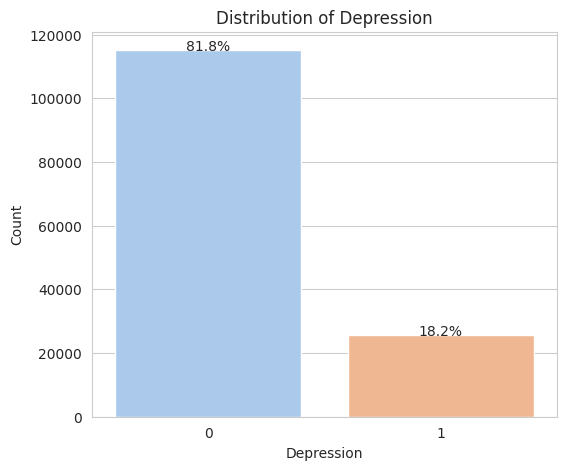

In [3]:
# Target Variable Distribution
plt.figure(figsize=(6, 5))
sns.countplot(x='depression', data=df, hue='depression', palette='pastel', legend=False)
plt.title('Distribution of Depression')
plt.xlabel('Depression')
plt.ylabel('Count')

# Calculate and display the percentage
total = len(df['depression'])
ax = plt.gca()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.,
            height + 5,
            f'{height/total:.1%}',
            ha="center")
plt.show()

The plot above shows that 81.8% of the individuals in the dataset are labeled as not having depression (0), while 18.2% are labeled as having depression (1). This class imbalance is important to consider in our modeling process.

# Distributions of Numerical Features

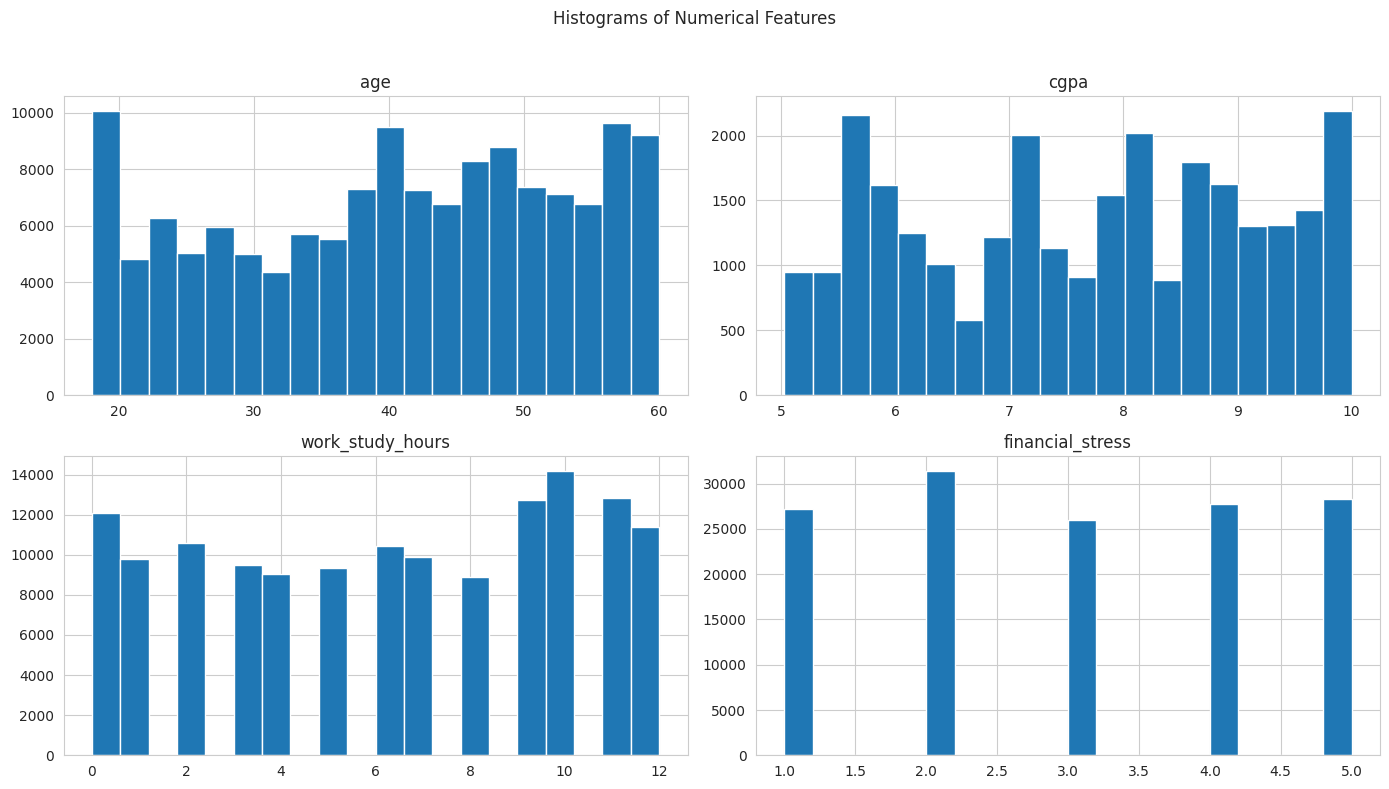

In [4]:
numerical_features = ['age', 'cgpa', 'work_study_hours', 'financial_stress']

# Histograms to see the distribution of each numerical feature
df[numerical_features].hist(bins=20, figsize=(14, 8), layout=(2, 2))
plt.suptitle('Histograms of Numerical Features')
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make room for suptitle
plt.show()


| Feature            | Distribution Shape / Characteristics                            | Interpretation / Possible Insights                              |
|--------------------|---------------------------------------------------------------|---------------------------------------------------------------|
| `age`              | Multimodal, with a large peak around 18-19 and a spread across 20-60 | The sample likely includes a large group of young students (~18) and a wide range of older adults. Possibly a mix of undergraduate and non-traditional students. |
| `cgpa`             | Fairly uniform with some peaks at whole numbers; slight increase towards higher CGPA values | CGPA is relatively evenly distributed, with more students clustering toward high-performing ranges (9-10). Suggests a good number of high achievers. |
| `work_study_hours` | Roughly uniform, with slight increases around 10-12 hours and 0 hours | Many students either do not work/study outside class or commit ~10-12 hours per week. A bimodal trend of part-timers and non-participants. |
| `financial_stress` | Discrete distribution with values 1-5; highest count at level 2 | Majority of students report moderate to low financial stress (mode around 2). Fewer report high stress (level 5). Overall skewed towards lower stress levels. |


# Numerical Features vs. Depression

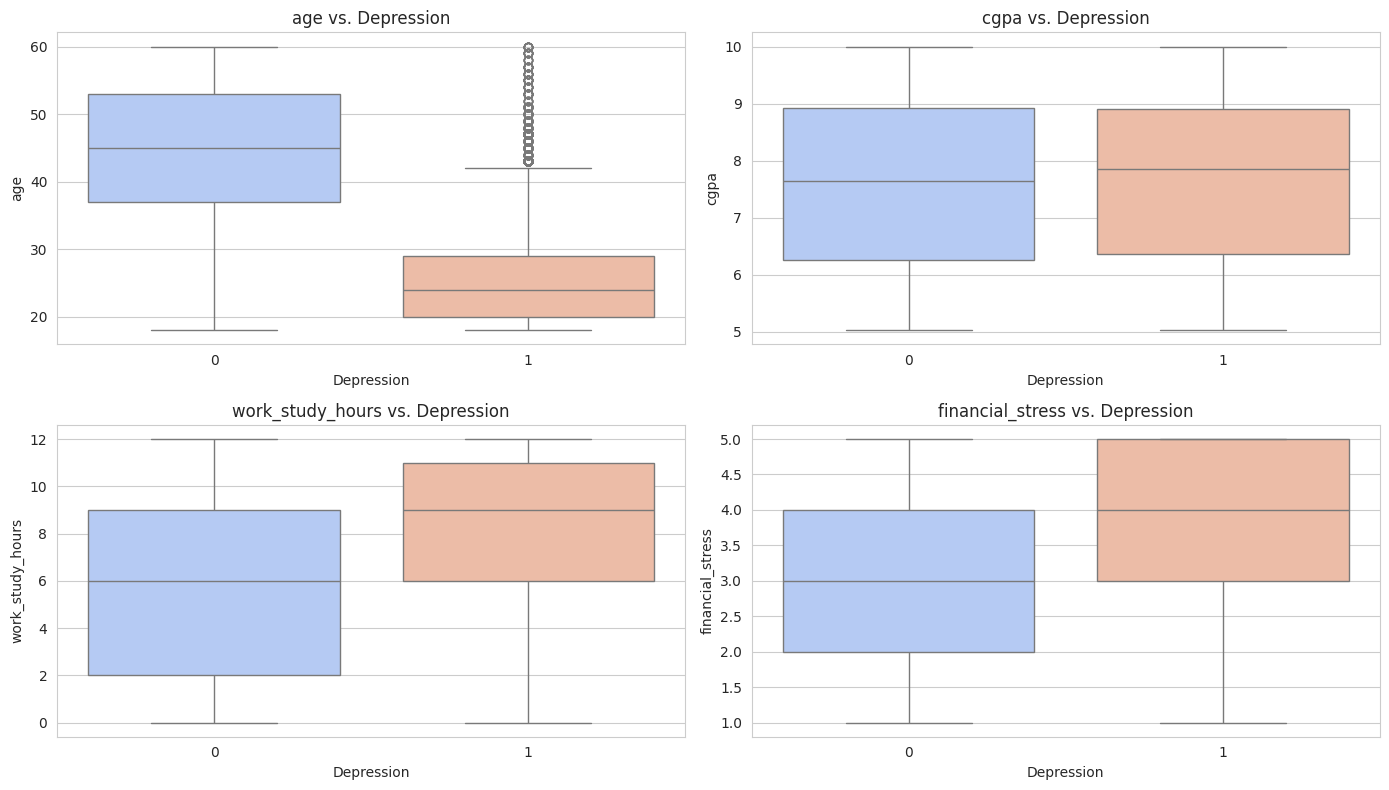

In [5]:
# Box plots to see the relationship between numerical features and Depression
plt.figure(figsize=(14, 8))
for i, col in enumerate(numerical_features):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(x='depression', y=col, data=df, hue='depression', palette='coolwarm', legend=False)
    plt.title(f'{col} vs. Depression')
    plt.xlabel('Depression')
    plt.ylabel(col)
plt.tight_layout()
plt.show()


| Feature            | Observed Relationship with Depression (0 = No, 1 = Yes)          | Interpretation / Possible Insight                                |
|--------------------|---------------------------------------------------------------|------------------------------------------------------------------|
| `age`              | Depressed group (1) is younger; median ~22 vs. ~45 for non-depressed | Younger individuals appear more likely to report depression in this sample. Could reflect age-related stress or reporting bias. |
| `cgpa`             | Similar medians; slightly wider spread for depressed group        | No strong relationship; academic performance appears fairly similar between groups. |
| `work_study_hours` | Higher median work/study hours among depressed group              | More work/study hours may be associated with increased depression risk, possibly due to stress or overcommitment. |
| `financial_stress` | Higher median financial stress among depressed group             | Clear relationship: Higher financial stress correlates with higher likelihood of depression. Financial factors likely play a role in well-being. |


# Correlation Matrix of Numerical Features

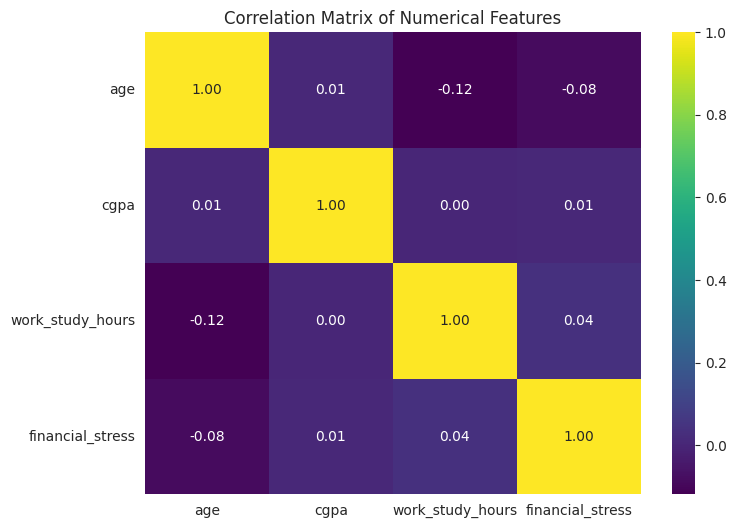

In [6]:
plt.figure(figsize=(8, 6))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

| Pair of Features             | Correlation Coefficient | Interpretation / Possible Insight                               |
|------------------------------|------------------------|---------------------------------------------------------------|
| `age` vs. `cgpa`             | 0.01                   | No meaningful relationship between age and CGPA.               |
| `age` vs. `work_study_hours` | -0.12                  | Weak negative correlation: younger students may work/study more.|
| `age` vs. `financial_stress` | -0.08                  | Very weak negative correlation: younger students may experience slightly more financial stress. |
| `cgpa` vs. `work_study_hours`| 0.00                   | No relationship between CGPA and work/study hours.              |
| `cgpa` vs. `financial_stress`| 0.01                   | No relationship between CGPA and financial stress.              |
| `work_study_hours` vs. `financial_stress` | 0.04    | Very weak positive correlation: slight tendency for students with more work/study hours to have higher financial stress. |


# Categorical Feature Analysis

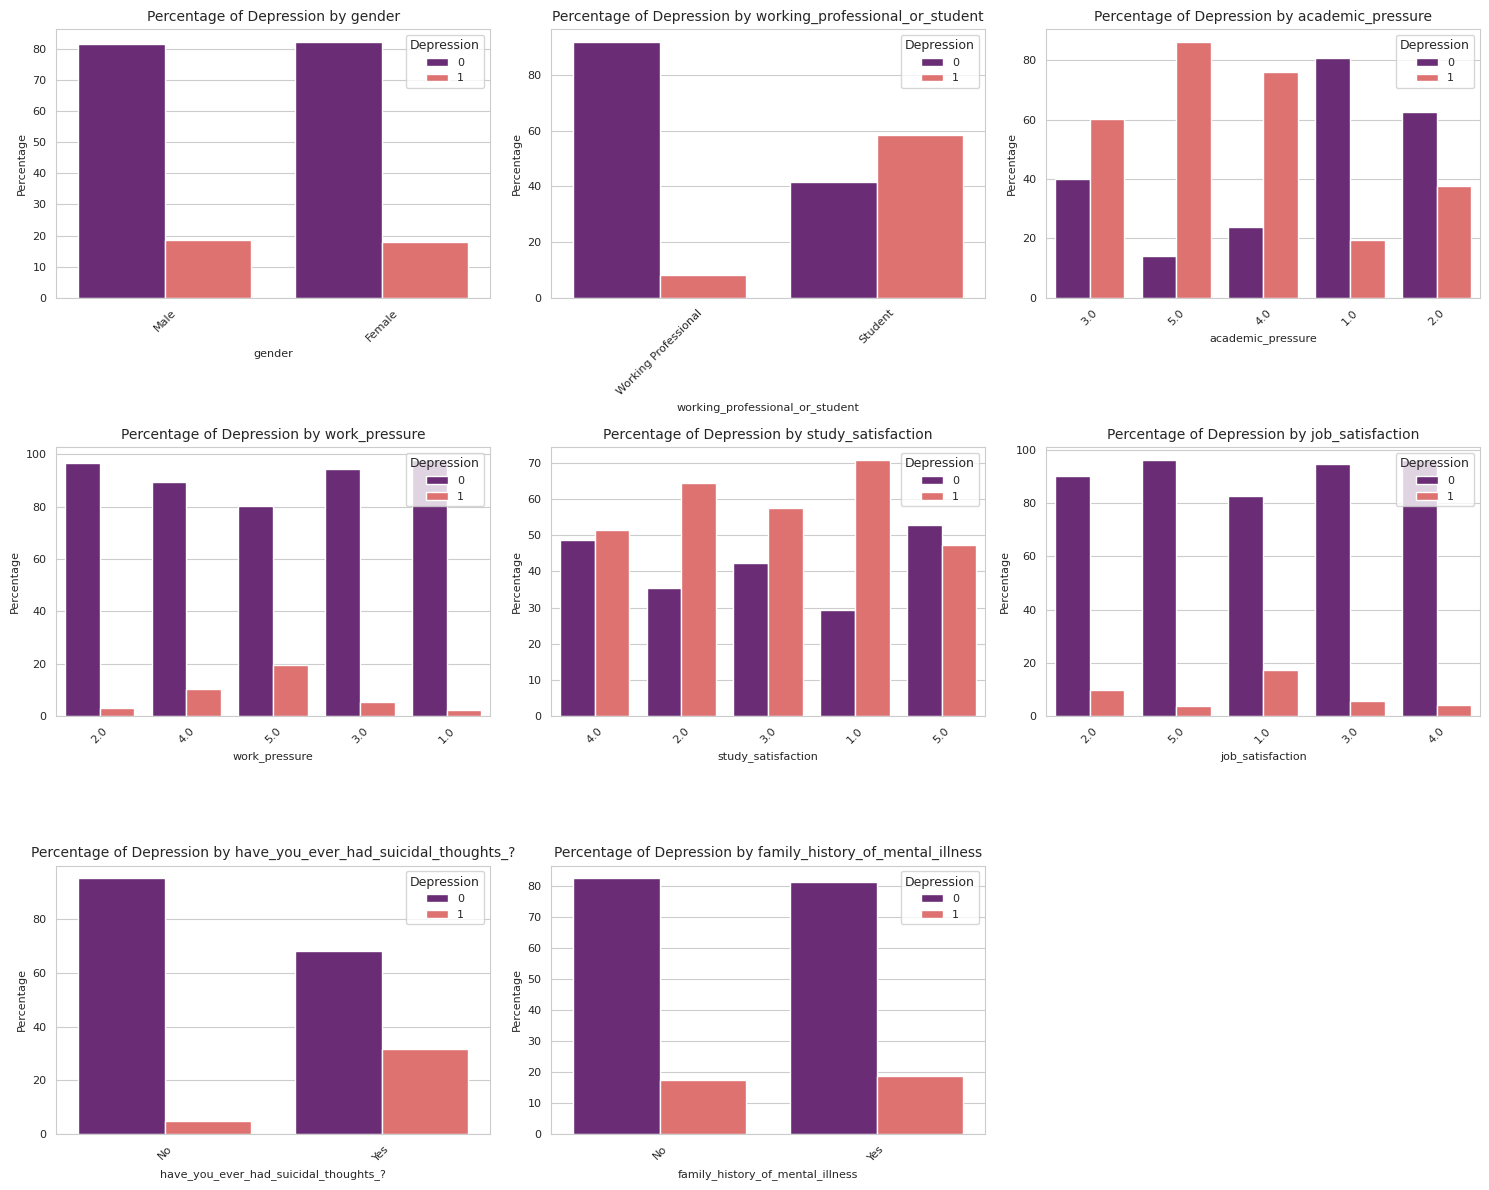

In [7]:
categorical_features = [
    'gender', 'working_professional_or_student', 'academic_pressure',
    'work_pressure', 'study_satisfaction', 'job_satisfaction',
    'sleep_duration', 'dietary_habits', 'have_you_ever_had_suicidal_thoughts_?',
    'family_history_of_mental_illness'
]


def plot_categorical_percentages_grid(df, features, target='depression', cols_per_row=3):
    n_features = len(features)
    n_cols = cols_per_row
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        # Calculate percentage of each target class per category
        percentage_df = df.groupby([feature, target]).size().reset_index(name='count')
        total_df = df.groupby(feature).size().reset_index(name='total')
        percentage_df = percentage_df.merge(total_df, on=feature)
        percentage_df['percentage'] = 100 * percentage_df['count'] / percentage_df['total']

        sns.barplot(ax=axes[i], x=feature, y='percentage', hue=target, data=percentage_df,
                    palette='magma', order=df[feature].value_counts().index)

        axes[i].set_title(f'Percentage of Depression by {feature}', fontsize=10)
        axes[i].set_xlabel(feature, fontsize=8)
        axes[i].set_ylabel('Percentage', fontsize=8)
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i].tick_params(axis='y', labelsize=8)
        axes[i].legend(title='Depression', fontsize=8, title_fontsize=9)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

exclude_features = ['sleep_duration', 'dietary_habits']

filtered_categorical_features = [f for f in categorical_features if f not in exclude_features]

plot_categorical_percentages_grid(df, filtered_categorical_features)

| Feature                               | Observed Relationship with Depression                  | Interpretation / Possible Insight |
|---------------------------------------|-------------------------------------------------------|-----------------------------------|
| gender                                | Very similar depression % for Male and Female          | No strong gender-based difference observed |
| working_professional_or_student       | Students show much higher depression % than professionals | Being a student is associated with higher depression risk |
| academic_pressure                     | Higher academic pressure (5, 4) linked to higher depression % | Strong positive relationship — academic stress appears impactful |
| work_pressure                         | Very low depression % across all work_pressure levels  | Little/no relationship — work pressure may not strongly affect depression in this sample |
| study_satisfaction                    | Lower study satisfaction linked to higher depression % | Inverse relationship — dissatisfaction strongly linked to depression |
| job_satisfaction                      | Lower job satisfaction linked to higher depression %   | Inverse relationship — dissatisfaction correlated with depression |
| have_you_ever_had_suicidal_thoughts_? | "Yes" group shows much higher depression %             | Very strong relationship — suicidal thoughts highly predictive of depression |
| family_history_of_mental_illness      | "Yes" group shows slightly higher depression %         | Family history is a mild risk factor but not as strong as e.g. study/job satisfaction or suicidal thoughts |


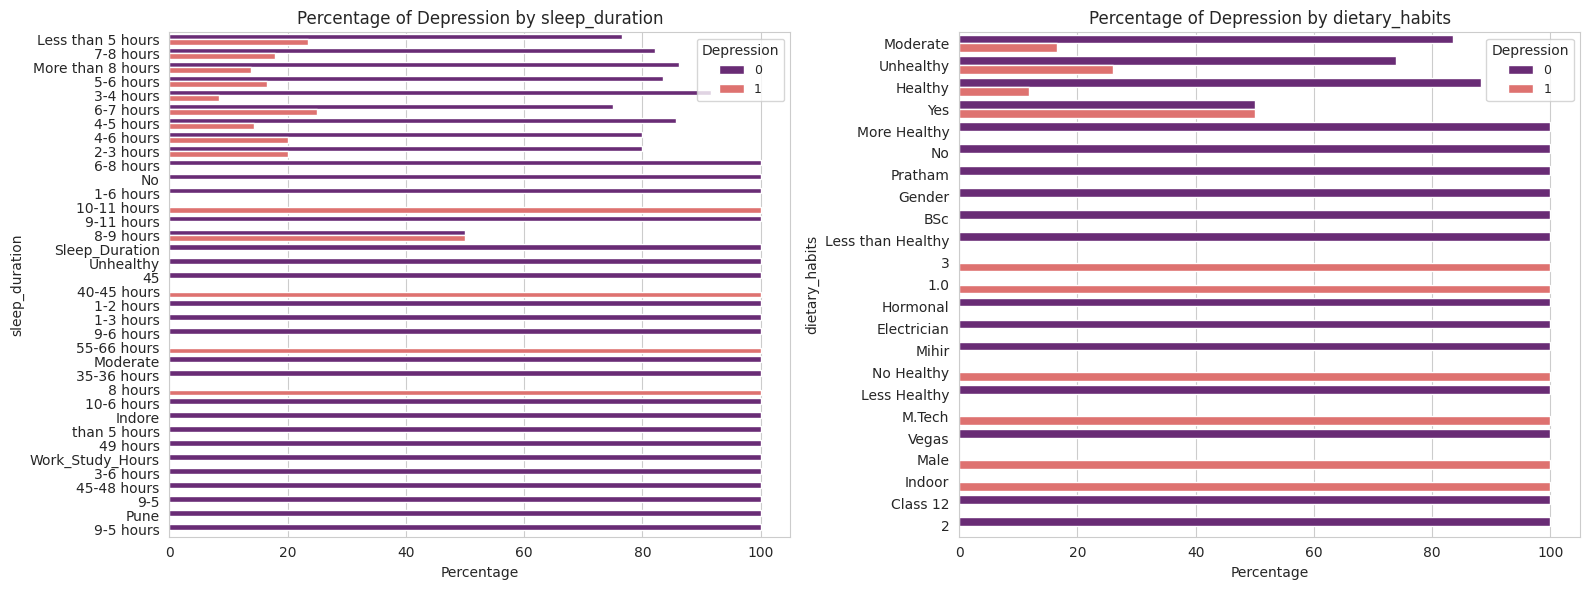

In [8]:
def plot_horizontal_categorical_percentages_side_by_side(df, features, target='depression'):
    n_features = len(features)
    fig, axes = plt.subplots(1, n_features, figsize=(n_features * 8, 6))

    if n_features == 1:
        axes = [axes]

    for i, feature in enumerate(features):
        percentage_df = df.groupby([feature, target]).size().reset_index(name='count')
        total_df = df.groupby(feature).size().reset_index(name='total')
        percentage_df = percentage_df.merge(total_df, on=feature)
        percentage_df['percentage'] = 100 * percentage_df['count'] / percentage_df['total']

        sns.barplot(ax=axes[i], y=feature, x='percentage', hue=target, data=percentage_df,
                    palette='magma', order=df[feature].value_counts().index)

        axes[i].set_title(f'Percentage of Depression by {feature}', fontsize=12)
        axes[i].set_ylabel(feature, fontsize=10)
        axes[i].set_xlabel('Percentage', fontsize=10)
        axes[i].legend(title='Depression', fontsize=9, title_fontsize=10)

    plt.tight_layout()
    plt.show()

plot_horizontal_categorical_percentages_side_by_side(df, ['sleep_duration', 'dietary_habits'])

| Feature         | Observed Relationship with Depression                        | Interpretation / Possible Insight |
|-----------------|-------------------------------------------------------------|-----------------------------------|
| sleep_duration  | - "Less than 5 hours", "5-6 hours", "6-7 hours", "4-5 hours" → higher depression % <br> - Optimal ranges ("7-8 hours", "More than 8 hours") → lower depression % <br> - Many noisy/miscategorized values (e.g. "Work_Study_Hours", "9-5") cluttering plot | **Clear relationship:** Short sleep duration is associated with higher depression % <br> **Data cleaning needed** — multiple inconsistent categories present |
| dietary_habits  | - "Moderate", "Unhealthy", "Healthy" show expected pattern (Unhealthy → higher depression %) <br> - Many noisy/miscategorized values (e.g. "Yes", "No", names, unrelated terms) → these have inconsistent patterns | **General trend:** Unhealthy dietary habits linked to higher depression % <br> **Data cleaning needed** — many irrelevant/mistyped values in `dietary_habits` column |


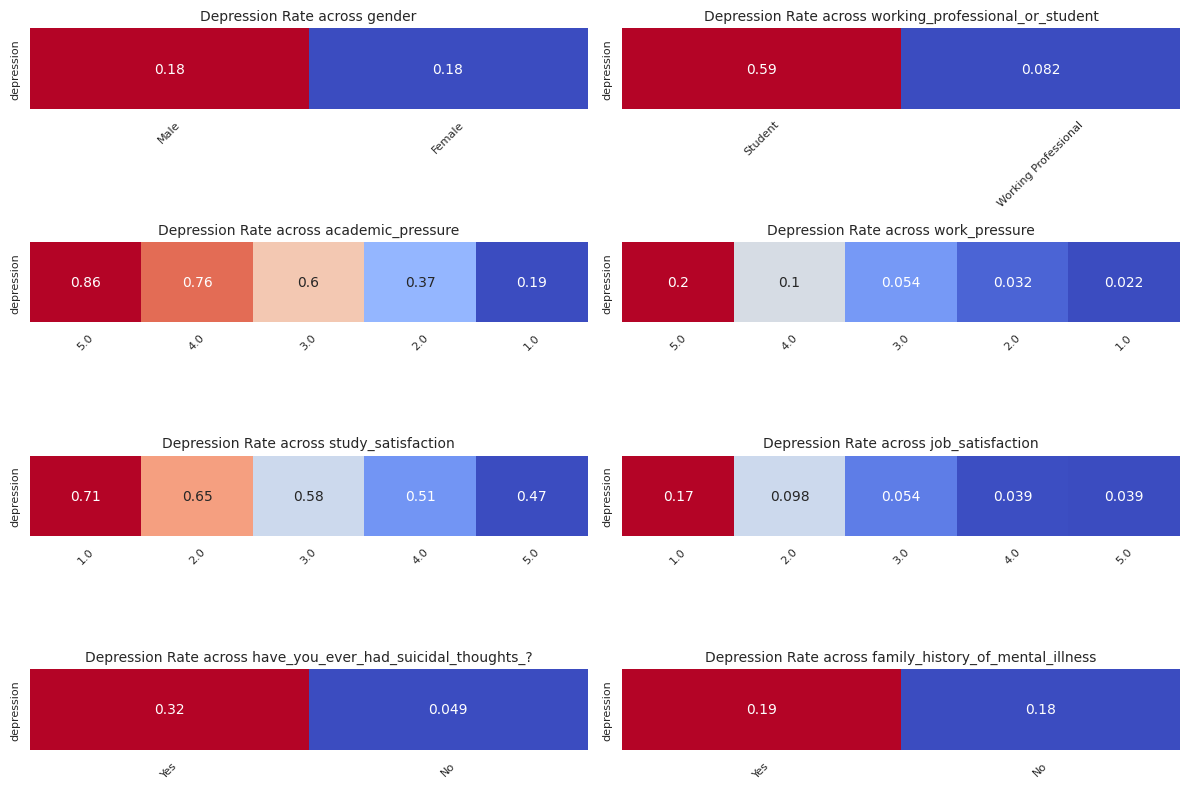

In [9]:
def depression_rate_heatmaps_grid(df, features, target='depression', cols_per_row=2, exclude_features=[]):
    features = [f for f in features if f not in exclude_features]

    n_features = len(features)
    n_cols = cols_per_row
    n_rows = (n_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 2))
    axes = axes.flatten()

    for i, feature in enumerate(features):
        rate_df = df.groupby(feature)[target].mean().reset_index()
        rate_df = rate_df.sort_values(by=target, ascending=False)

        sns.heatmap(rate_df[[target]].T, annot=True, cmap='coolwarm', cbar=False,
                    xticklabels=rate_df[feature], ax=axes[i])

        axes[i].set_title(f'Depression Rate across {feature}', fontsize=10)
        axes[i].tick_params(axis='x', rotation=45, labelsize=8)
        axes[i].tick_params(axis='y', labelsize=8)

    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

depression_rate_heatmaps_grid(df, categorical_features, exclude_features=['sleep_duration', 'dietary_habits'])

| Feature                               | Observed Relationship with Depression                  | Interpretation / Possible Insight |
|---------------------------------------|-------------------------------------------------------|-----------------------------------|
| gender                                | Same depression rate (~18%) for both Male and Female   | No gender-based difference observed |
| working_professional_or_student       | Students: 59% <br> Working Professionals: 8%           | Being a student strongly linked to higher depression |
| academic_pressure                     | Strong gradient: higher academic pressure → higher depression (86% at level 5 → 19% at level 1) | Academic stress is a major factor for depression |
| work_pressure                         | Depression decreases with lower work pressure <br> Max: 20% (level 5), Min: ~2% (level 1) | Work stress impacts depression but less dramatically than academic pressure |
| study_satisfaction                    | Inverse relationship: lower satisfaction → higher depression <br> 71% at level 1 → 47% at level 5 | Study dissatisfaction is a significant depression risk factor |
| job_satisfaction                      | Similar inverse relationship: lower job satisfaction → higher depression <br> 17% at level 1 → ~4% at level 5 | Job dissatisfaction linked to depression risk |
| have_you_ever_had_suicidal_thoughts_? | "Yes": 32% <br> "No": 4.9%                            | Very strong relationship — suicidal thoughts highly predictive of depression |
| family_history_of_mental_illness      | "Yes": 19% <br> "No": 18%                              | Slight increase in depression with family mental illness history, but not strong in this sample |


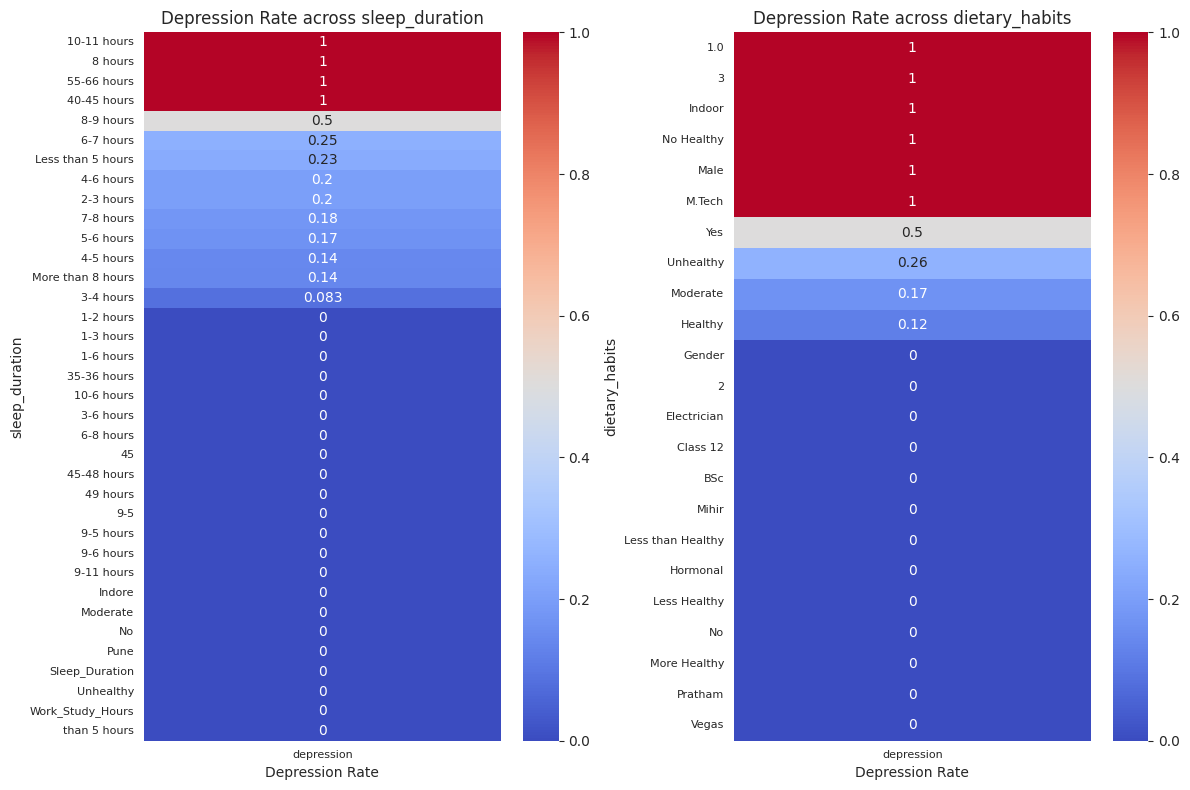

In [10]:
def depression_rate_heatmaps_horizontal(df, features, target='depression'):
    n_features = len(features)
    fig, axes = plt.subplots(1, n_features, figsize=(n_features * 6, 8))

    if n_features == 1:
        axes = [axes]

    for i, feature in enumerate(features):
        rate_df = df.groupby(feature)[target].mean().reset_index()
        rate_df = rate_df.sort_values(by=target, ascending=False)

        sns.heatmap(rate_df.set_index(feature), annot=True, cmap='coolwarm', cbar=True, ax=axes[i])

        axes[i].set_title(f'Depression Rate across {feature}', fontsize=12)
        axes[i].set_xlabel('Depression Rate', fontsize=10)
        axes[i].set_ylabel(feature, fontsize=10)

        axes[i].tick_params(axis='x', rotation=0, labelsize=8)
        axes[i].tick_params(axis='y', rotation=0, labelsize=8)

    plt.tight_layout()
    plt.show()

depression_rate_heatmaps_horizontal(df, ['sleep_duration', 'dietary_habits'])

| Feature         | Observed Relationship with Depression                        | Interpretation / Possible Insight |
|-----------------|-------------------------------------------------------------|-----------------------------------|
| sleep_duration  | - Very short sleep (<= 5-6 hrs) → Higher depression (up to 25%) <br> - Moderate sleep (6-8 hrs) → Lower depression (14-18%) <br> - Long sleep (8-11 hrs) → Some entries show **100% depression**, likely due to small N (warning) <br> - Many noisy values (0 depression) → needs data cleaning | General trend: **short or irregular sleep → higher depression** <br> Long sleep spikes likely artifacts <br> Clean category values to improve signal |
| dietary_habits  | - "Unhealthy" → Higher depression (26%) <br> - "Moderate" → 17% <br> - "Healthy" → 12% <br> - Many irrelevant/noisy values (Gender, Class 12, Vegas, etc) with 0 depression — needs cleaning | **Unhealthy dietary habits are linked to higher depression** <br> Noise in categories should be cleaned to reveal clearer pattern |

| Metric / Result                     | Observation / Value                                    | Interpretation / Possible Insight |
|-------------------------------------|------------------------------------------------------|-----------------------------------|
| Accuracy                            | 0.18                                                 | Very low accuracy; model is misclassifying majority class 0 as class 1 |
| Confusion Matrix (True 0 vs Pred)    | 4 true negatives, 23,023 false positives              | Model is predicting almost all 0s as 1s (major false positive problem) |
| Confusion Matrix (True 1 vs Pred)    | 5,113 true positives, 0 false negatives               | Model is correctly predicting all 1s → recall for class 1 is 1.0 |
| Precision (Class 0)                 | 1.00                                                 | Model predicted a few 0s — all correct, but very few predictions of 0 made |
| Recall (Class 0)                    | 0.00                                                 | Model failed to recall true 0s → massive bias toward predicting 1 |
| F1-Score (Class 0)                  | 0.00                                                 | Model has no ability to correctly predict class 0 |
| Precision (Class 1)                 | 0.18                                                 | Many false positives → low precision for class 1 |
| Recall (Class 1)                    | 1.00                                                 | Model predicts all class 1 correctly → recall is perfect for class 1 |
| F1-Score (Class 1)                  | 0.31                                                 | Low F1-score; imbalance between precision and recall |
| Macro Avg F1-Score                  | 0.15                                                 | Very low overall model balance across both classes |
| Weighted Avg F1-Score               | 0.06                                                 | Even lower when accounting for class imbalance (class 0 dominates) |
| ROC AUC                             | 0.50                                                 | Model is no better than random guessing (ROC AUC ~ 0.50) |


# Feature Identification and Preprocessing Pipeline
- Feature-Target Split:

  - The target_column ('depression') is isolated from the main DataFrame.
  - X is defined as the feature matrix (all columns except the target).
  - y is defined as the target vector (the 'depression' column).
- Automated Feature Identification:

  - The code automatically identifies categorical and numerical features based on their data types (dtype). This makes the pipeline adaptable to changes in the dataset.
- Numerical Feature Pipeline (numerical_transformer):

  - A Pipeline object is created to process all numerical columns.
  - Imputation: SimpleImputer(strategy='mean') is used to fill any missing numerical values with the mean of their respective columns.
  - Scaling: StandardScaler() is applied to standardize the features (e.g., transform them to have a mean of 0 and a standard deviation of 1), which is crucial for the performance of many models like Logistic Regression.
- Categorical Feature Pipeline (categorical_transformer):

  - A separate Pipeline handles all categorical columns.
  - Imputation: SimpleImputer(strategy='most_frequent') fills any missing categorical values with the mode (most frequent value) of their column.
  - Encoding: OneHotEncoder(handle_unknown='ignore') converts the categorical text data into a numerical format by creating binary columns for each category, preventing the model from misinterpreting the data.
- Combined Preprocessor (ColumnTransformer):

  - The ColumnTransformer is the final step that combines the numerical and categorical pipelines.
  - It applies the appropriate transformation (numerical_transformer or categorical_transformer) to the correct columns, creating a single, unified preprocessing object that can be seamlessly integrated into a model training workflow.

In [11]:
target_column = 'depression'
X = df.drop(target_column, axis=1)
y = df[target_column]

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

In [12]:
print(f"Categorical Features: {list(categorical_features)}")
print(f"Numerical Features: {list(numerical_features)}")

# Create a pipeline for numerical features:
# 1. Impute missing values with the mean
# 2. Scale the features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Create a pipeline for categorical features:
# 1. Impute missing values with the most frequent category
# 2. One-hot encode the categories
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine these pipelines into a single preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])


Categorical Features: ['name', 'gender', 'city', 'working_professional_or_student', 'profession', 'sleep_duration', 'dietary_habits', 'degree', 'have_you_ever_had_suicidal_thoughts_?', 'family_history_of_mental_illness']
Numerical Features: ['id', 'age', 'academic_pressure', 'work_pressure', 'cgpa', 'study_satisfaction', 'job_satisfaction', 'work_study_hours', 'financial_stress']


# Split data into training and testing sets

In [13]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nOriginal training labels: {Counter(y_train)}")



Original training labels: Counter({0: 86350, 1: 19175})


Given the class imbalance, we use SMOTE (Synthetic Minority Over-sampling Technique) to create synthetic samples of the minority class (depression=1) in our training data. This helps to prevent the model from being biased towards the majority class.

# Handle Class Imbalance with SMOTE (synthetic minority over-sampling technique)

In [14]:

# SMOTE should only be applied to the training data
smote = SMOTE(random_state=42)
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"Resampled training labels: {Counter(y_train_resampled)}")

Resampled training labels: Counter({1: 86350, 0: 86350})


# Define Models and Parameter Grids
- Model Initialization: The models dictionary is defined to hold the machine learning algorithms for evaluation. This setup allows for iterating through each model systematically.

  - The models chosen are: Logistic Regression, Random Forest, and XGBoost.
Each model is instantiated with a random_state=42 to ensure the reproducibility of results.
  - Hyperparameter Grid Definition: The param_grids dictionary specifies the search space for the GridSearchCV process. Each key corresponds to a model, and its value is a dictionary of hyperparameters with the different values to be tested.

- Logistic Regression: The grid tests various values for C, which controls the inverse of regularization strength.
  - Random Forest: The search space includes n_estimators (the number of trees in the forest), max_depth (the maximum depth of each tree), and min_samples_leaf (the minimum number of samples required at a leaf node).
  - XGBoost: The grid is set to explore different combinations of n_estimators, max_depth, and learning_rate to find the optimal balance between model performance and complexity.

In [15]:

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
}

param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1.0, 10.0]
    },
    'Random Forest': {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_leaf': [1, 4]
    },
    'XGBoost': {
        'classifier__n_estimators': [50, 100],
        'classifier__max_depth': [3, 5],
        'classifier__learning_rate': [0.1, 0.2]
    }
}


# Train and Tune Models using GridSearchCV
- Purpose: A primary technique for hyperparameter tuning, used to find the optimal settings to maximize a model's performance.
- Methodology: It performs an exhaustive search (hence "Grid Search") across a manually defined "grid" of parameter values.
- Evaluation: For each combination of hyperparameters in the grid, it uses k-fold cross-validation (CV). This provides a robust estimate of the model's performance for that specific set of parameters by training and validating it on different subsets of the data.
- Scoring: The effectiveness of each parameter combination is judged based on a specified performance metric, such as F1-score, accuracy, or AUC.
- Outcome: After testing all possible combinations, GridSearchCV identifies and returns the set of hyperparameters that yielded the highest average cross-validation score, representing the optimal configuration for the model.

In [16]:

best_estimators = {}
for name in models.keys():
    print(f'\n--- Tuning {name} ---')

    # Create a full pipeline with the classifier
    # Note: We don't need the preprocessor here since we already processed the data
    # However, a pipeline is best practice if you don't use SMOTE separately
    # For this example, we fit directly on the pre-processed, resampled data

    # Using a simplified param grid since the preprocessor is not in a pipeline
    simple_param_grid = {key.split('__')[1]: value for key, value in param_grids[name].items()}

    grid_search = GridSearchCV(
        estimator=models[name],
        param_grid=simple_param_grid,
        cv=3, # 3-fold cross-validation
        scoring='f1_weighted', # Focus on F1-score
        n_jobs=-1, # Use all available cores
        verbose=1
    )

    # Fit on the resampled training data
    grid_search.fit(X_train_resampled, y_train_resampled)

    best_estimators[name] = grid_search.best_estimator_
    print(f"Best Score (F1-weighted): {grid_search.best_score_:.4f}")
    print(f"Best Parameters: {grid_search.best_params_}")



--- Tuning Logistic Regression ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Score (F1-weighted): 0.9326
Best Parameters: {'C': 10.0}

--- Tuning Random Forest ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Score (F1-weighted): 0.9469
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 100}

--- Tuning XGBoost ---
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [14:06:37] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Score (F1-weighted): 0.9439
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


# Model evaluation


 Evaluation for Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.92      0.95     28783
           1       0.73      0.91      0.81      6392

    accuracy                           0.92     35175
   macro avg       0.85      0.92      0.88     35175
weighted avg       0.93      0.92      0.93     35175



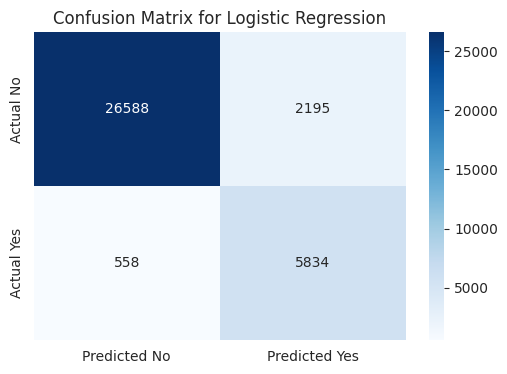


 Evaluation for Random Forest
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     28783
           1       0.77      0.83      0.80      6392

    accuracy                           0.93     35175
   macro avg       0.87      0.89      0.88     35175
weighted avg       0.93      0.93      0.93     35175



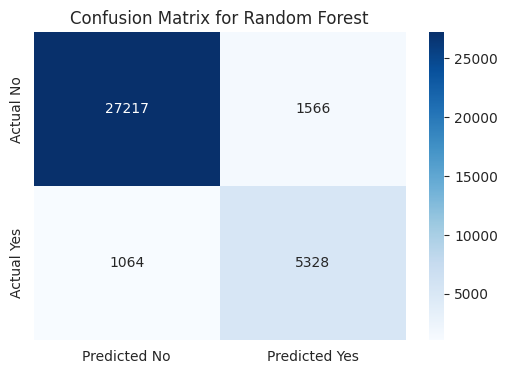


 Evaluation for XGBoost
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     28783
           1       0.79      0.86      0.82      6392

    accuracy                           0.93     35175
   macro avg       0.88      0.90      0.89     35175
weighted avg       0.94      0.93      0.93     35175



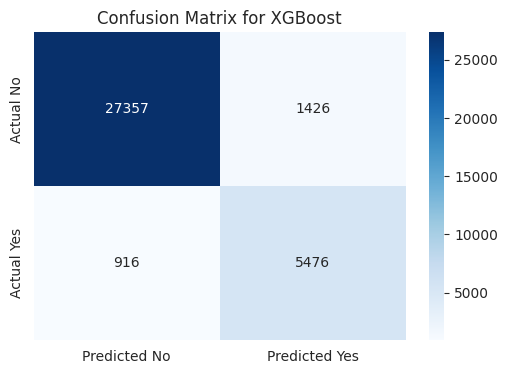

In [17]:

for name, model in best_estimators.items():
    print(f"\n Evaluation for {name}")

    # Make predictions on the original, non-resampled test set
    y_pred = model.predict(X_test_processed)

    # Classification Report
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted No', 'Predicted Yes'],
                yticklabels=['Actual No', 'Actual Yes'])
    plt.title(f'Confusion Matrix for {name}')
    plt.show()


# Conclusion

In [18]:
# Find the best model based on F1-score on the test set
best_model_name = ''
best_f1 = 0.0

for name, model in best_estimators.items():
    y_pred = model.predict(X_test_processed)
    f1 = f1_score(y_test, y_pred, average='weighted')
    if f1 > best_f1:
        best_f1 = f1
        best_model_name = name

print(f"The best performing model is '{best_model_name}' with a weighted F1-score of {best_f1:.4f} on the test data.")


The best performing model is 'XGBoost' with a weighted F1-score of 0.9344 on the test data.
